### Getting and Displaying Census Data
+ Package dotenv allows us to load API keys from .env files which are in .git_ignore to keep them private. 
    - The `secrets.env` file only needs one line that reads: `uscb_api_key = '<your API key>''`
    - To request an API key: https://api.census.gov/data/key_signup.html
    - Census API documentation: https://www.census.gov/data/developers/data-sets.html
    
- Package [`us`](https://pypi.org/project/us/) will give you FIPS codes for locations as well as shapefiles from TIGER.
    - Fun fact! TIGER stands for "Topologically Integrated Geographic Encoding and Referencing".
+ Package [`census`](https://pypi.org/project/census/) pulls down data from the US Census Bureau (USCB)

The code below is based on the documentation for the [`census`](https://pypi.org/project/census/) package.

In [43]:
#!pip install census
#!pip install us

In [134]:
import os
import gc
import requests

import matplotlib.pyplot as plt
import pandas as pd

from dotenv import load_dotenv
from zipfile import ZipFile

from census import Census
import us

import contextily as ctx 
import geopandas as gpd

from tqdm import tqdm

In [173]:
# Import census API key - returns true if successful
load_dotenv('./secrets.env')

True

In [171]:
uscb_api_key = os.getenv('uscb_api_key')

In [139]:
# This function, when given a url, will download a zip file  to `dl_folder` and extract its contents
# into `ext_folder` 
def download_and_unzip_files(url, ext, ext_folder = './ext_files/', dl_folder = './downloaded_files/'):
    
    # check for and make output_folders
    if not os.path.exists(ext_folder):
        os.makedirs(folder_name)
    if not os.path.exists(dl_folder):
        os.makedirs(dl_folder)

    # Download url to dl_folder
    url = url
    filename = url.rsplit('/', 1)[1]
    r = requests.get(url, allow_redirects=True)
    open(dl_folder + filename, 'wb').write(r.content)
    #print(filename)

    # extract files with ext to ext_folder
    with ZipFile(dl_folder + filename, 'r') as zip_file:
        ## to extrat only a certain kind of file
        #shapefile = [file for file in zip_file.namelist() if file.endswith(ext)][0]
        #zip_file.extract(shapefile, ext_folder)
        
        # to extract all files
        zip_file.extractall(ext_folder)

In [140]:
# get a list of all objects in memory
all_objects = gc.get_objects()

# filter the list to only include instances of MyClass
myclass_instances = [obj for obj in all_objects if isinstance(obj, us.states.State)]

tract_urls = [ ]
# iterate over all instances
for instance in myclass_instances:
    if 'tract' in instance.shapefile_urls():
        #print(instance)
        #print(instance.shapefile_urls()['tract'])
        tract_urls.append(instance.shapefile_urls()['tract'])

In [141]:
# Download the .zip files from USCB        
for url in tqdm(tract_urls, desc ="Download Progress"):
    download_and_unzip_files(url, '.shp', ext_folder = './tract_shapefiles/')

Download Progress: 100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:16<00:00,  3.30it/s]


### Let us draw those shapefiles, won't you?

### Geopandas
Tutorial: ([link](https://medium.com/@jl_ruiz/plot-maps-from-the-us-census-bureau-using-geopandas-and-contextily-in-python-df787647ef77))

In [168]:
# List of shapefiles (slow)
folder_path = './tract_shapefiles/'
shapefile_list = [folder_path + f for f in os.listdir(folder_path) if f.endswith('.shp')]

# Read in each shapefile as a GeoDataFrame and combine them into one
gdf = gpd.GeoDataFrame(pd.concat([gpd.read_file(file) for file in shapefile_list], ignore_index=True), crs=gpd.read_file(shapefile_list[0]).crs)

<Axes: >

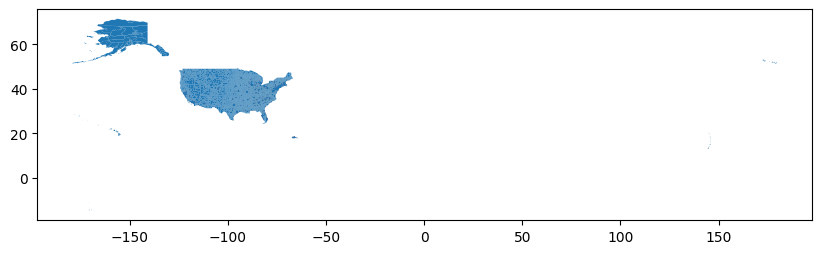

In [169]:
# Plot the GeoDataFrame using GeoPandas' plot function
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GeoDataFrame using GeoPandas' plot function
gdf.plot(ax=ax,xlim=bbox[:2], ylim=bbox[2:])
# Show the plot
plt.show()